In [1]:
import os
import glob
import cv2
import numpy as np
import random
from adjustText import adjust_text
import plotly.express as px
from tifffile import TiffFile
import os
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt

random.seed(42)

base_dir = r"N:\00_Exchange\Alois\data\data_processed"
os.chdir(r"N:\\00_Exchange\\Alois")



In [2]:
import os
import numpy as np
import pandas as pd
from tifffile import TiffFile, imread
def compute_leakage_fraction(data_folder):
    results = []
    
    treatments = ['FG12', 'PBS', '11C7', 'NG004']
    
    for treatment in treatments:
        vessel_path = os.path.join(data_folder, 'data_processed', treatment)
        original_path = os.path.join(data_folder, treatment)
        mask_path = os.path.join(data_folder, 'retina_masks', treatment)
       
        for subject in os.listdir(vessel_path):
            print(f'Processing subject: {subject}')
            
            subject_folder = os.path.join(vessel_path, subject)
            original_file = os.path.join(original_path, f'{subject}.tif')
            vessel_file = os.path.join(subject_folder, f'{subject}_reconstructed_multi.tif')
            subjectID = subject.split('_')[0]
            retina_filtered = os.path.join(subject_folder, f'{subjectID}_retina_mask_filtered.tif')
            mask_file = os.path.join(mask_path, f'{subject}_mask.tif')

            if os.path.exists(vessel_file) and os.path.exists(mask_file) and os.path.exists(original_file):
                vessel_img = np.stack([page.asarray() for page in TiffFile(vessel_file).pages])
                original_img = imread(original_file)
                mask_img = imread(mask_file)
                retina_filt_img = imread(retina_filtered)

                num_layers = min(original_img.shape[0], mask_img.shape[0], vessel_img.shape[0])
                
                for layer in range(num_layers):
                    original_layer = original_img[layer]
                    mask_layer = mask_img[layer]
                    retina_filtered_layer = retina_filt_img[layer]
                    
                    area_image = mask_layer - retina_filtered_layer
                    
                    threshold = 2.5
                    masked_area_image = np.where((area_image > 0) & (original_layer > threshold), original_layer, 0)
                    
                    valid_pixels = (masked_area_image > 0).sum()
                    if valid_pixels > 0:
                        MeanGrayValue = masked_area_image.sum() / valid_pixels
                    else:
                        MeanGrayValue = 0
                    
                    eye = 'OD' if 'OD' in subject else 'OE'
                    results.append({
                        'Treatment': treatment,
                        'SubjectID': subject,
                        'Eye': eye,
                        'LayerNumber': layer,
                        'MeanGrayValue': MeanGrayValue
                    })
    
    results_df = pd.DataFrame(results)
    return results_df

In [3]:

data_folder = 'data_full'
df = compute_leakage_fraction(data_folder)


Processing subject: Akita28_OD_25x
Processing subject: Akita28_OE_25x
Processing subject: Akita30_OD_25x
Processing subject: Akita30_OE_25x
Processing subject: Akita32_OD_25x
Processing subject: Akita32_OE_25x
Processing subject: Akita33_OD_25x
Processing subject: Akita33_OE_25x
Processing subject: Akita34_OD_25x
Processing subject: Akita34_OE_25x
Processing subject: Akita35_OD_25x
Processing subject: Akita35_OE_25x
Processing subject: Akita36_OD_25x
Processing subject: Akita36_OE_25x
Processing subject: Akita37_OD_25x
Processing subject: Akita37_OE_25x
Processing subject: Akita13_OD_25x
Processing subject: Akita13_OE_25x
Processing subject: Akita17_OD_25x
Processing subject: Akita17_OE_25x
Processing subject: Akita18_OD_25x
Processing subject: Akita18_OE_25x
Processing subject: Akita46_OD_25x
Processing subject: Akita46_OE_25x
Processing subject: Akita47_OD_25x
Processing subject: Akita47_OE_25x
Processing subject: Akita48_OD_25x
Processing subject: Akita48_OE_25x
Processing subject: 

In [4]:
df['SubjectID'] = df['SubjectID'].str.extract(r'Akita(\d+)')


In [5]:
df.to_csv('leakage_MGV_layers.csv', index=False)


In [6]:
df = pd.read_csv('leakage_MGV_layers.csv')


## Plots

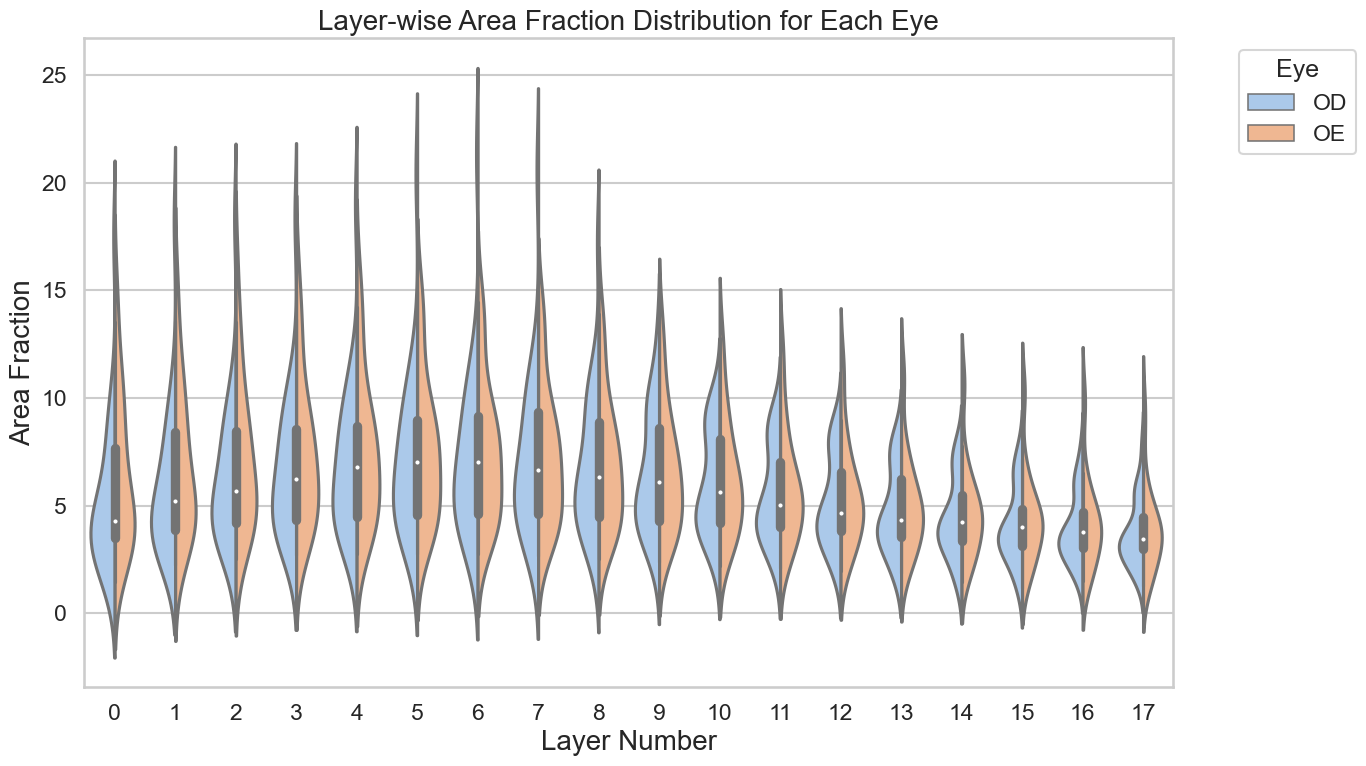

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(14, 8))
sns.set(style="whitegrid", context="talk")

violin_plot = sns.violinplot(x="LayerNumber", y="MeanGrayValue", hue="Eye", data=df, palette="pastel", split=True)

plt.title('Layer-wise MGV Leakage Distribution for Each Eye', fontsize=20)
plt.xlabel('Layer Number', fontsize=20)
plt.ylabel('MGV Leakage', fontsize=20)
plt.legend(title='Eye', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


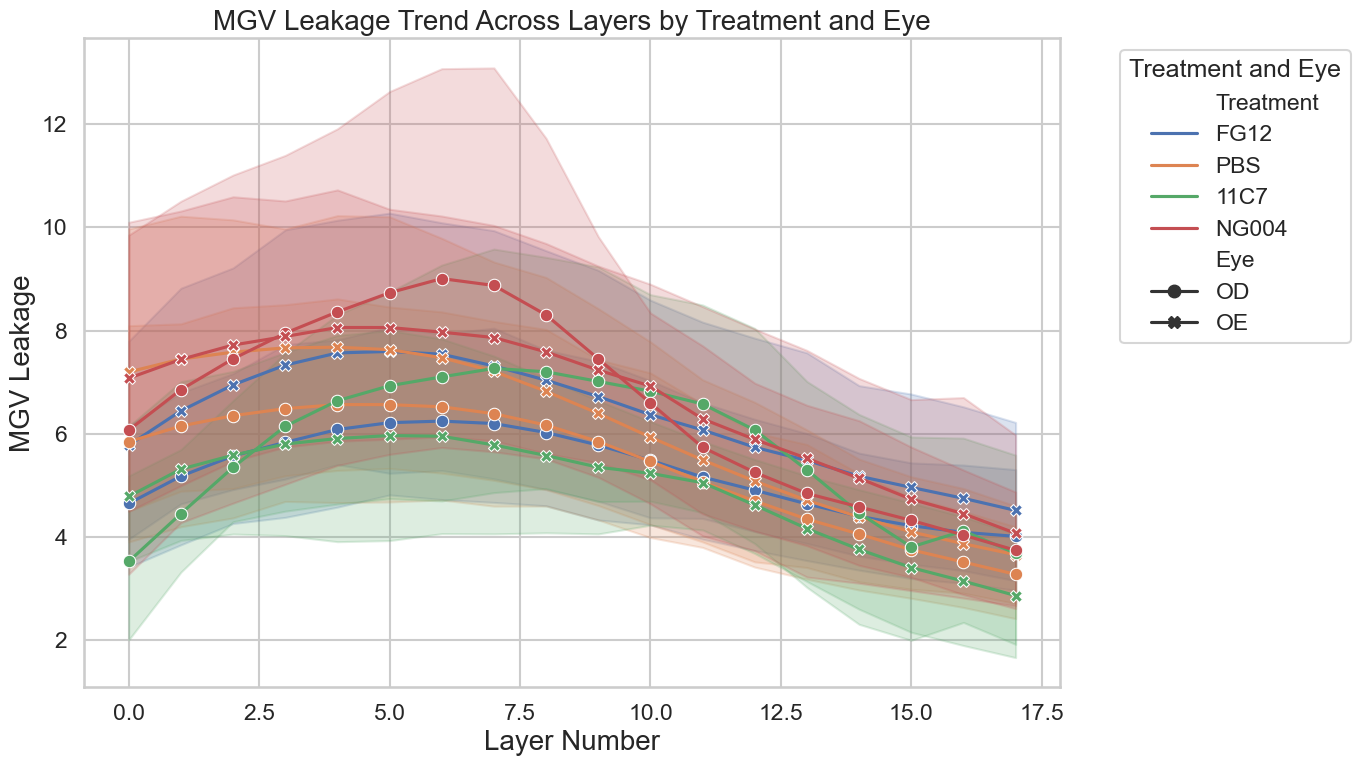

In [9]:
plt.figure(figsize=(14, 8))
sns.lineplot(x="LayerNumber", y="MeanGrayValue", hue="Treatment", style="Eye", markers=True, dashes=False, data=df)
plt.title('MGV Leakage Trend Across Layers by Treatment and Eye', fontsize=20)
plt.xlabel('Layer Number', fontsize=20)
plt.ylabel('MGV Leakage', fontsize=20)
plt.legend(title='Treatment and Eye', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


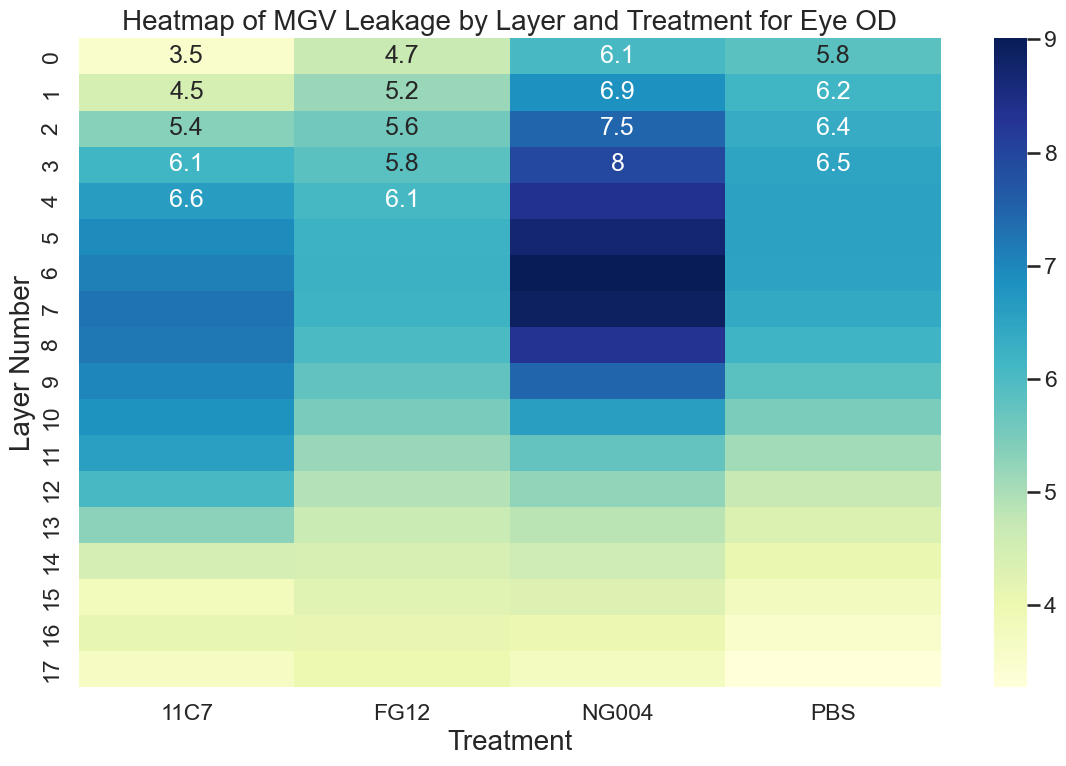

In [10]:
heatmap_data = df[df['Eye'] == 'OD'].pivot_table(index='LayerNumber', columns='Treatment', values='MeanGrayValue', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")
plt.title('Heatmap of MGV Leakage by Layer and Treatment for Eye OD', fontsize=20)
plt.xlabel('Treatment', fontsize=20)
plt.ylabel('Layer Number', fontsize=20)
plt.tight_layout()
plt.show()


## Plots by treatment

c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


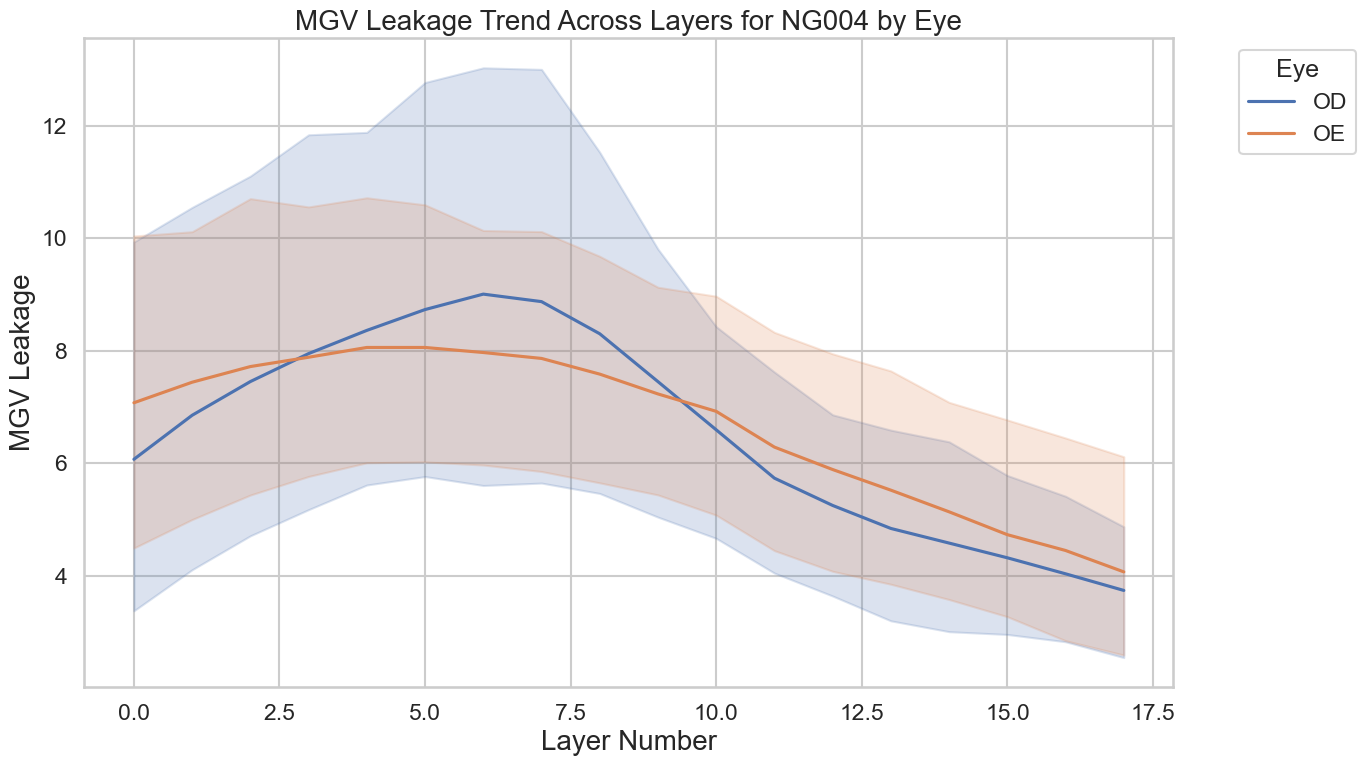

In [15]:
treatment = 'NG004'
df_filtered = df[df['Treatment'] == treatment]

plt.figure(figsize=(14, 8))
sns.lineplot(x="LayerNumber", y="MeanGrayValue", hue="Eye", markers=True, dashes=False, data=df_filtered)
plt.title(f'MGV Leakage Trend Across Layers for {treatment} by Eye', fontsize=20)
plt.xlabel('Layer Number', fontsize=20)
plt.ylabel('MGV Leakage', fontsize=20)
plt.legend(title='Eye', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


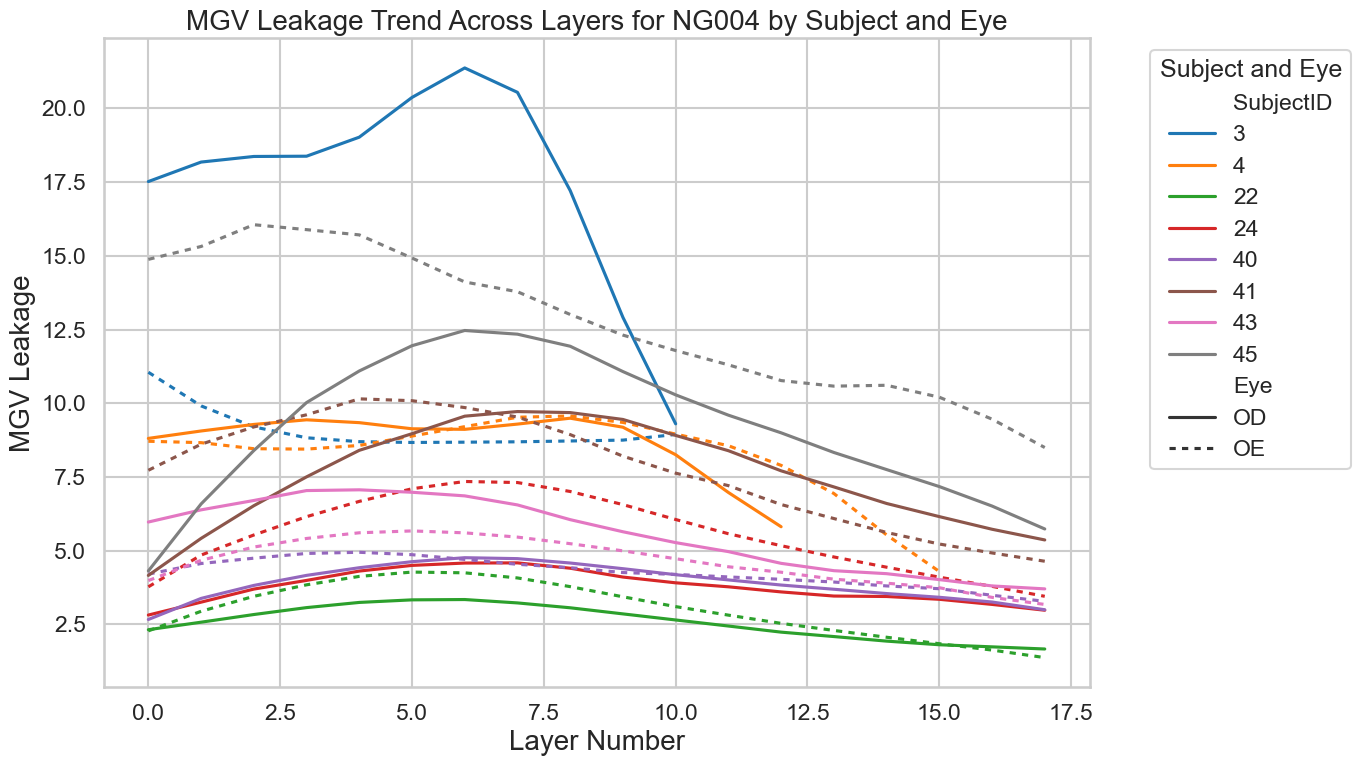

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


treatment = 'NG004'
df_filtered = df[df['Treatment'] == treatment]

plt.figure(figsize=(14, 8))

style_order = ["OD", "OE"]
dashes = {'OD': '', 'OE': (2, 2)}  


sns.lineplot(x="LayerNumber", y="MeanGrayValue", hue="SubjectID", style="Eye",
             dashes=dashes, data=df_filtered, palette="tab10", style_order=style_order)

plt.title(f'MGV Leakage Trend Across Layers for {treatment} by Subject and Eye', fontsize=20)
plt.xlabel('Layer Number', fontsize=20)
plt.ylabel('MGV Leakage', fontsize=20)

plt.legend(title='Subject and Eye', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Delta OD-OE

In [17]:
df_filtered = df.dropna(subset=['MeanGrayValue'])
df_pivot = df_filtered.pivot_table(index=['SubjectID', 'Treatment', 'LayerNumber'], columns='Eye', values='MeanGrayValue').reset_index()
df_pivot['MeanGrayValueDiff'] = df_pivot['OD'] - df_pivot['OE']
df_diff = df_pivot.melt(id_vars=['SubjectID', 'Treatment', 'LayerNumber'], value_vars=['MeanGrayValueDiff'], 
                        var_name='Metric', value_name='MeanGrayValue').dropna()

df_diff = df_diff[['SubjectID', 'Treatment', 'LayerNumber', 'MeanGrayValue']]
df_diff['DeltaMeanGrayValue'] = df_diff['MeanGrayValue']


c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


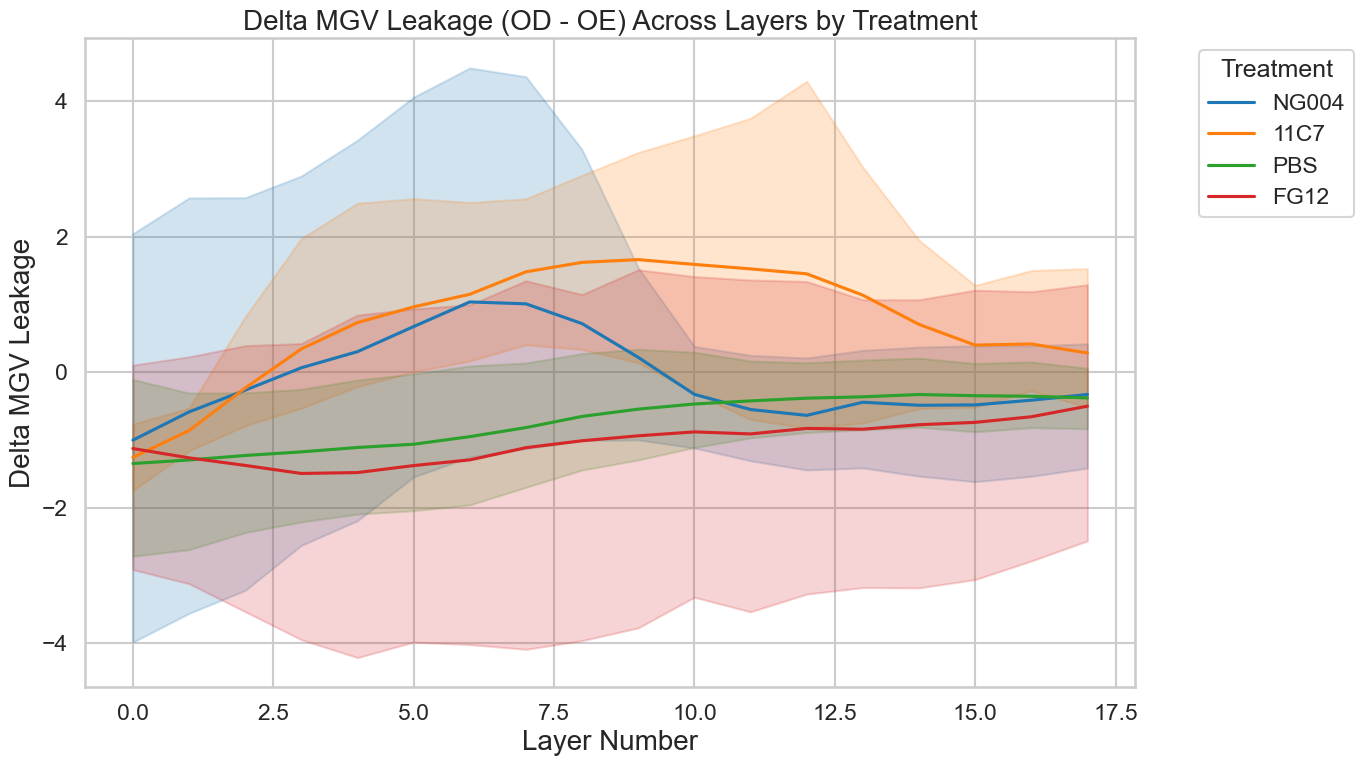

In [18]:
plt.figure(figsize=(14, 8))

sns.lineplot(x="LayerNumber", y="DeltaMeanGrayValue", hue="Treatment", data=df_diff, markers=True, dashes=False, palette='tab10')

plt.title('Delta MGV Leakage (OD - OE) Across Layers by Treatment', fontsize=20)
plt.xlabel('Layer Number', fontsize=20)
plt.ylabel('Delta MGV Leakage', fontsize=20)
plt.legend(title='Treatment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


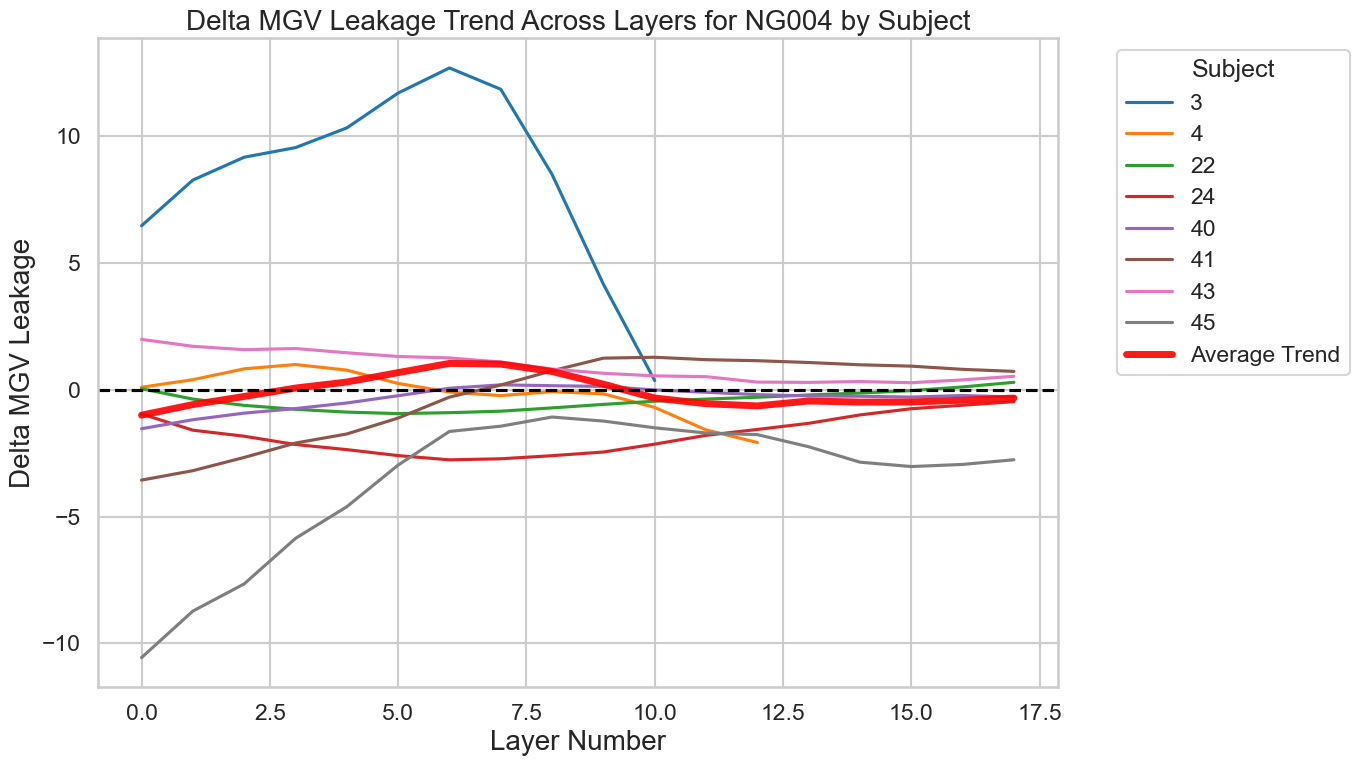

In [19]:
treatment = 'NG004'
df_filtered = df_diff[df_diff['Treatment'] == treatment]

plt.figure(figsize=(14, 8))

sns.lineplot(x="LayerNumber", y="DeltaMeanGrayValue", hue="SubjectID", markers=True, dashes=False,
             data=df_filtered, palette="tab10")

average_trend = df_filtered.groupby("LayerNumber")["DeltaMeanGrayValue"].mean()

plt.plot(average_trend.index, average_trend.values, color='red', linewidth=5, alpha=0.9, label='Average Trend')

plt.title(f'Delta MGV Leakage Trend Across Layers for {treatment} by Subject', fontsize=20)
plt.xlabel('Layer Number', fontsize=20)
plt.ylabel('Delta MGV Leakage', fontsize=20)

plt.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


# Entropy selection evaluation

In [20]:

df_max = df.loc[df.groupby(['SubjectID', 'Eye', 'Treatment'])['MeanGrayValue'].idxmax()]
df_max = df_max[['Treatment','SubjectID', 'Eye', 'LayerNumber', 'MeanGrayValue']]
df_max['SubjectID'] = df_max['SubjectID'].astype('int64')


In [21]:


import re


folders = ['PBS', 'FG12', 'NG004', '11C7']

data = []

pattern = r"Akita(?P<SubjectID>\d+)_(?P<Eye>OD|OE)_25x_stack_(?P<LayerNumber>\d+).tif"

for treatment in folders:
    folder_path = os.path.join('data', treatment)
    
    if os.path.exists(folder_path):
        for file in os.listdir(folder_path):
            if re.match(pattern, file) and 'contrast' not in file:
                match = re.match(pattern, file)
                if match:
                    data.append({
                        'Treatment': treatment,
                        'SubjectID': match.group('SubjectID'),
                        'Eye': 'OD' if match.group('Eye') == 'OD' else 'OE',
                        'LayerNumber': int(match.group('LayerNumber')),
                    })

df_entropy = pd.DataFrame(data)
df_entropy['SubjectID'] = df_entropy['SubjectID'].astype('int64')



c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


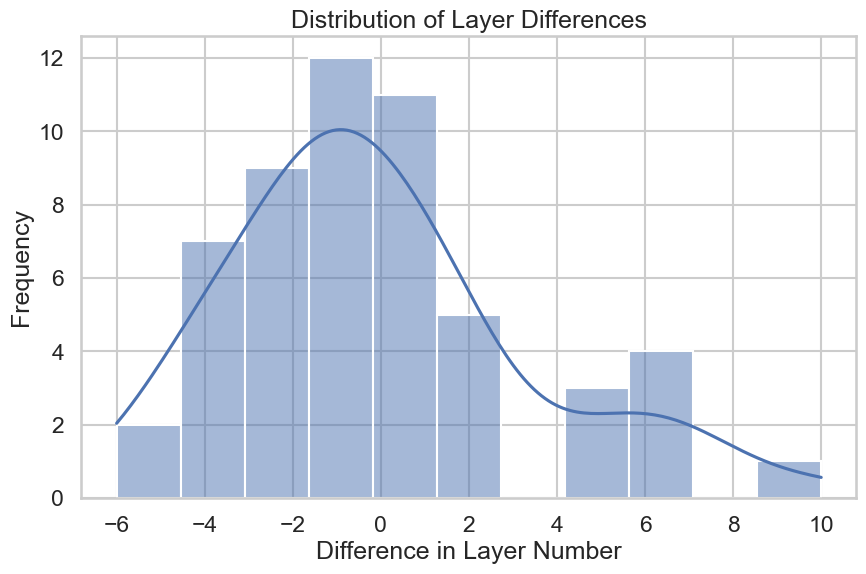

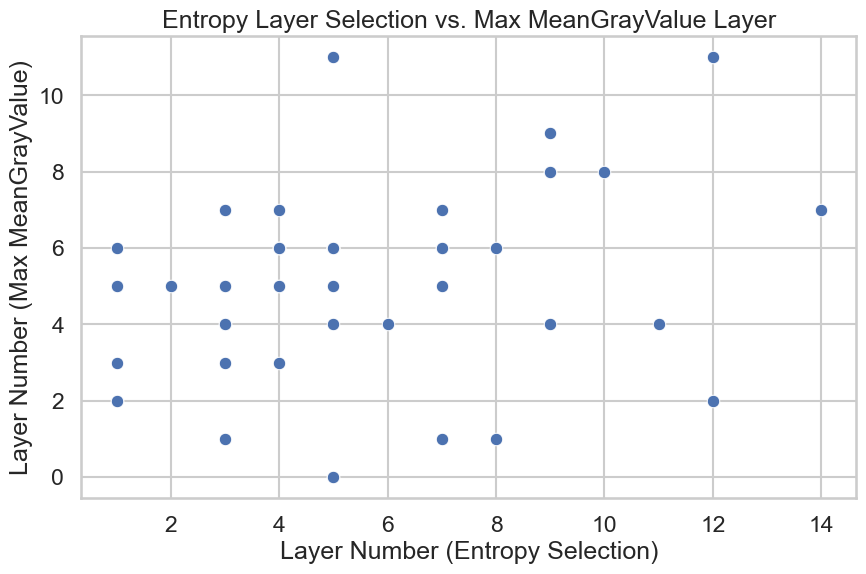

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



merged_df = pd.merge(df_entropy, df_max, on=['SubjectID', 'Eye'], suffixes=('_entropy', '_max'))

merged_df['LayerDifference'] = merged_df['LayerNumber_entropy'] - merged_df['LayerNumber_max']

plt.figure(figsize=(10, 6))
sns.histplot(merged_df['LayerDifference'], kde=True)
plt.title('Distribution of Layer Differences')
plt.xlabel('Difference in Layer Number')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='LayerNumber_entropy', y='LayerNumber_max', data=merged_df)
plt.title('Entropy Layer Selection vs. Max MeanGrayValue Layer')
plt.xlabel('Layer Number (Entropy Selection)')
plt.ylabel('Layer Number (Max MeanGrayValue)')
plt.show()




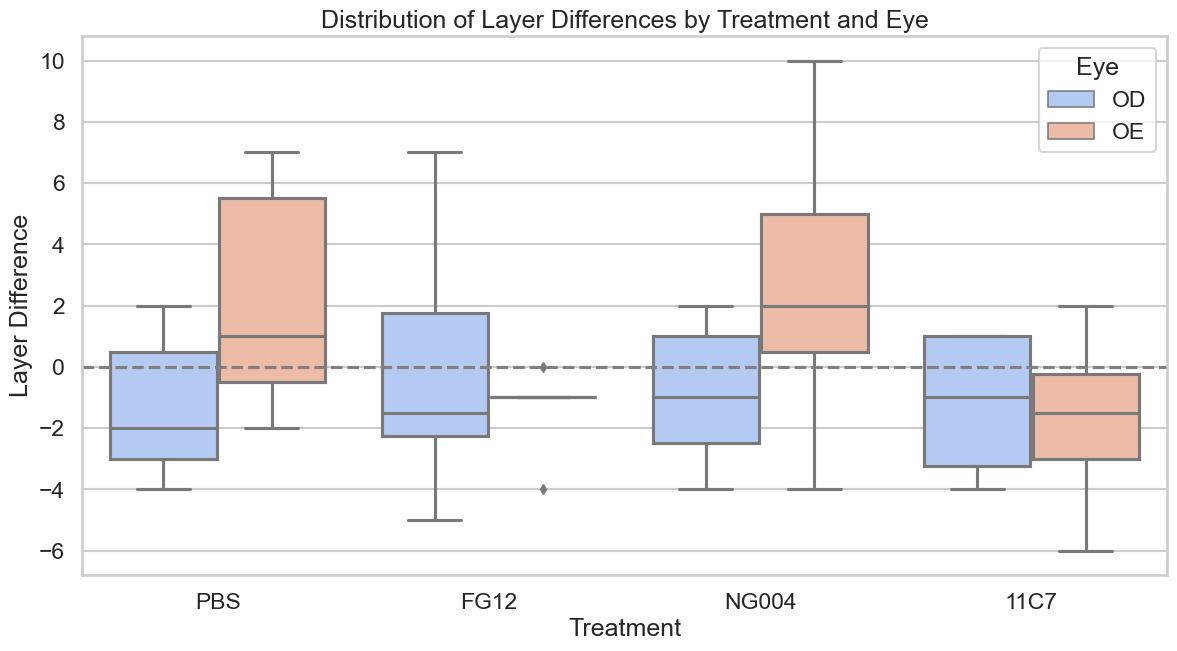

In [23]:
grouped_diff = merged_df.groupby(['Treatment_max', 'Eye'])['LayerDifference'].mean().reset_index()

plt.figure(figsize=(14, 7))
sns.boxplot(x='Treatment_max', y='LayerDifference', hue='Eye', data=merged_df, palette='coolwarm')
plt.title('Distribution of Layer Differences by Treatment and Eye')
plt.xlabel('Treatment')
plt.ylabel('Layer Difference')
plt.axhline(0, color='gray', linestyle='--')  # Adds a reference line at 0 difference
plt.legend(title='Eye')
plt.show()


In [24]:
std_dev = np.std(merged_df['LayerDifference'])

n = len(merged_df['LayerDifference'])

std_error = std_dev / np.sqrt(n)

print(f"Standard Error of the Layer Differences: {std_error}")

Standard Error of the Layer Differences: 0.4595899070809179


In [26]:
import numpy as np

grouped_stats = merged_df.groupby(['Treatment_max', 'Eye'])['LayerDifference'].agg(['std', 'count']).reset_index()

grouped_stats['SE'] = grouped_stats['std'] / np.sqrt(grouped_stats['count'])

grouped_stats.rename(columns={'std': 'Standard Deviation', 'count': 'Count', 'SE': 'Standard Error'}, inplace=True)
print(grouped_stats[['Treatment_max', 'Eye', 'Standard Deviation', 'Count', 'Standard Error']])




  Treatment_max Eye  Standard Deviation  Count  Standard Error
0          11C7  OD            2.629956      4        1.314978
1          11C7  OE            3.304038      4        1.652019
2          FG12  OD            4.486090      8        1.586072
3          FG12  OE            1.164965      8        0.411877
4         NG004  OD            2.267787      8        0.801784
5         NG004  OE            4.242641      8        1.500000
6           PBS  OD            2.360387      7        0.892143
7           PBS  OE            3.638419      7        1.375193


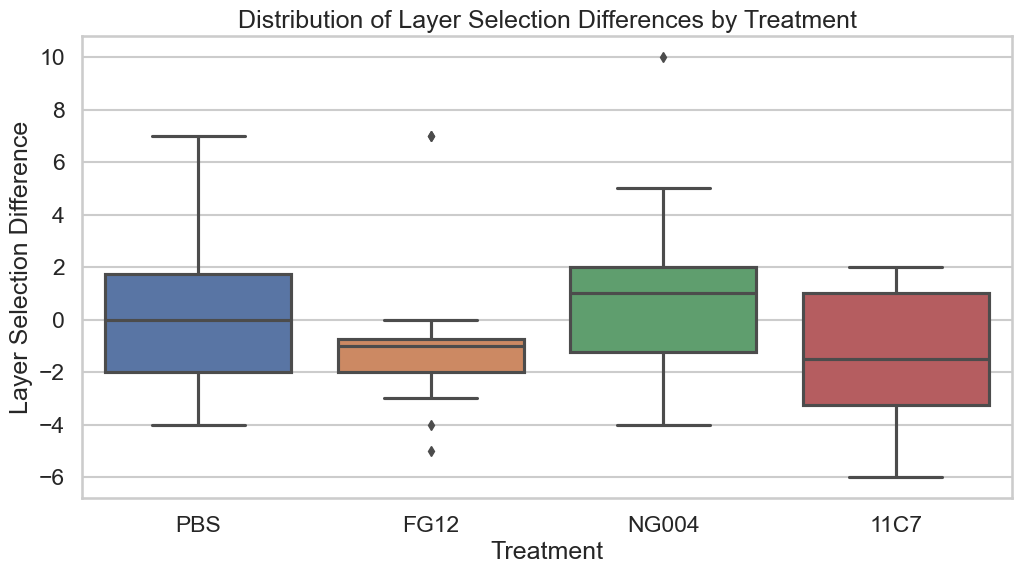

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

merged_df['LayerDifference'] = merged_df['LayerNumber_entropy'] - merged_df['LayerNumber_max']

plt.figure(figsize=(12, 6))
sns.boxplot(x='Treatment_max', y='LayerDifference', data=merged_df)
plt.title('Distribution of Layer Selection Differences by Treatment')
plt.xlabel('Treatment')
plt.ylabel('Layer Selection Difference')
plt.show()


# Evaluation of entropy selection

In [28]:


df_entropy['Eye'] = df_entropy['Eye'].replace({'OD': 'Right', 'OE': 'Left'})
df_max['Eye'] = df_max['Eye'].replace({'OD': 'Right', 'OE': 'Left'})

merged_df = pd.merge(df_entropy, df_max, on=['SubjectID', 'Eye', 'Treatment'], suffixes=('_entropy', '_max'))


In [29]:
merged_df['AbsLayerDifference'] = (merged_df['LayerNumber_entropy'] - merged_df['LayerNumber_max']).abs()
merged_df['LayerDifference'] = merged_df['LayerNumber_entropy'] - merged_df['LayerNumber_max']
mad_by_treatment = merged_df.groupby('Treatment')['AbsLayerDifference'].mean().reset_index()

print("Mean Absolute Difference by Treatment:")
print(mad_by_treatment)


Mean Absolute Difference by Treatment:
  Treatment  AbsLayerDifference
0      11C7            2.500000
1      FG12            2.312500
2     NG004            2.875000
3       PBS            2.642857


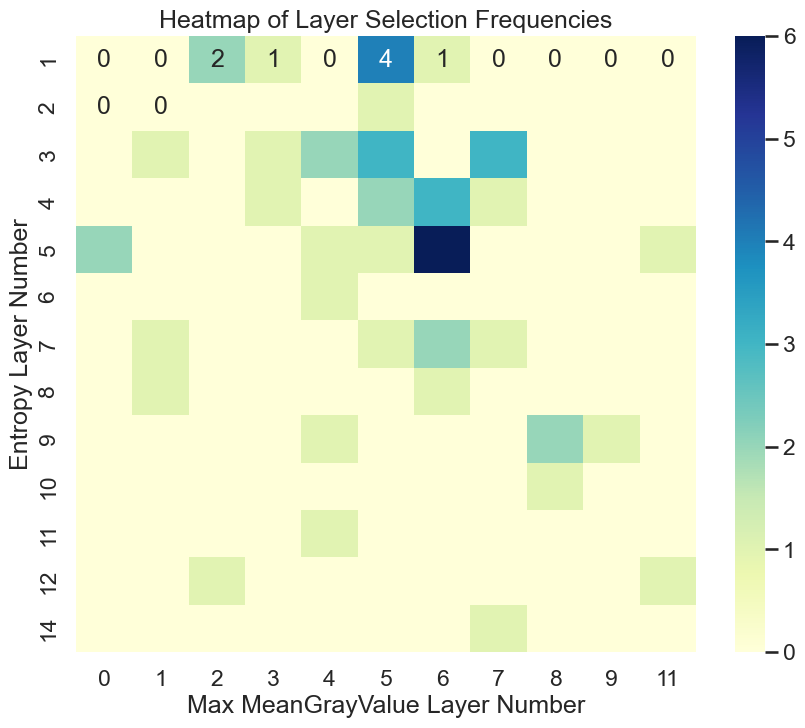

In [30]:

layer_counts = merged_df.groupby(['LayerNumber_entropy', 'LayerNumber_max']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(layer_counts, cmap="YlGnBu", annot=True, fmt="d")
plt.title('Heatmap of Layer Selection Frequencies')
plt.xlabel('Max MeanGrayValue Layer Number')
plt.ylabel('Entropy Layer Number')
plt.show()


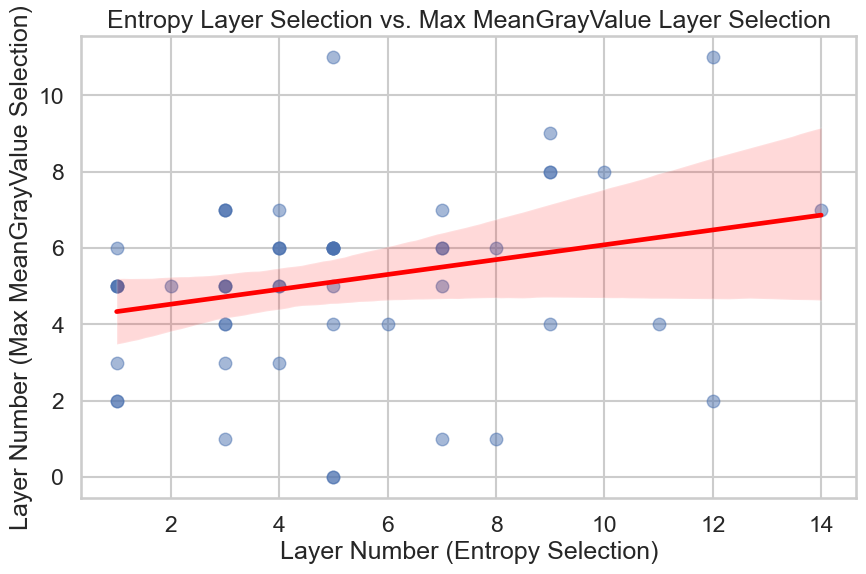

In [31]:
plt.figure(figsize=(10, 6))
sns.regplot(x='LayerNumber_entropy', y='LayerNumber_max', data=merged_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Entropy Layer Selection vs. Max MeanGrayValue Layer Selection')
plt.xlabel('Layer Number (Entropy Selection)')
plt.ylabel('Layer Number (Max MeanGrayValue Selection)')
plt.show()


In [32]:
correlation = merged_df['AbsLayerDifference'].corr(merged_df['MeanGrayValue'])
print(f"Pearson Correlation Coefficient: {correlation}")


Pearson Correlation Coefficient: 0.05917775021132612
